# Analyze N-Back Data

In [1]:
%matplotlib inline

import os 
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from nltools.data import Brain_Data, Adjacency, Design_Matrix
from nltools.file_reader import onsets_to_dm
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import regress
from nilearn.plotting import plot_img_on_surf, plot_stat_map, plot_glass_brain, view_img_on_surf
import nibabel as nib
import mne
from mne.io import read_raw_snirf
import mne.io.snirf
from snirf import Snirf
import h5py
from kernel.utils import load_snirf_file, get_resource_path, get_optodes, extract_stimulus_data, pick_channels_from_distance_mne_epochs

mne.viz.set_3d_backend("notebook")

base_dir = '/Users/lukechang/Dropbox/Kernel'

Using notebook 3d backend.



## Analyze NIFTI Reconstruction with nltools

To speed up loading data, we save a resampled version of the data. Alternatively, we could load it in the original 4 x 4 x 4 space like we do using nibabel below.

The nifti reconstructed data has been trimmed to 1 sec before start experiment and 1 sec after experiment end.

We are seeing large scaling differences across regions, so z-scoring data for now, but that means we are losing absolute HbO concentrations

Mask is s k=50 whole brain parcellation based on neurosynth coactivations. Target ROIs correspond to left and right somatomotor cortex

In [ ]:
# metadata = {'subject':'S001', 'task_name':'GoNoGo', 'task_id':'8e7c446'}
metadata = {'subject':'S003', 'task_name':'GoNoGo', 'task_id':'5b7a6da'}

# data_nifti = Brain_Data(os.path.join(base_dir, 'Data', metadata["task_name"],  f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO.nii.gz') )
# data_nifti.write(os.path.join(base_dir, 'Data', metadata["task_name"],  f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO_resampled.nii.gz'))

data_nifti = Brain_Data(os.path.join(base_dir, 'Data', metadata["task_name"], f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO_resampled.nii.gz') )
data_nifti = data_nifti.standardize(method='zscore')
toffset =  nib.load(os.path.join(base_dir, 'Data', metadata["task_name"], f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO.nii.gz')).header['toffset']
n_tr = len(data_nifti)

mask = Brain_Data(os.path.join(get_resource_path(), 'k50_2mm.nii.gz'))
mask_x = expand_mask(mask)

mask_x[44].plot()
plt.show()

/opt/anaconda3/envs/mne/lib/python3.11/site-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


### Create Design_Matrix

Extract event information and plot average activity within each ROI

/var/folders/5b/m183lc3x27n9krrzz85z2x1c0000gn/T/ipykernel_33707/2864377120.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  events['block_type'].fillna('rest', inplace=True)
/opt/anaconda3/envs/mne/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converte

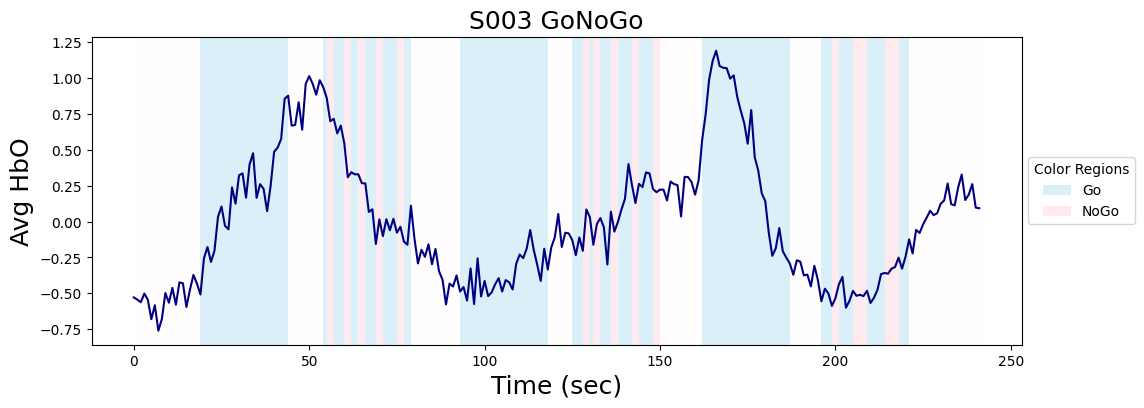

In [8]:
events = pd.read_csv(os.path.join(base_dir, 'Data', metadata['task_name'], f'Test_{metadata["subject"]}_{metadata["task_id"]}_task_events.tsv'), sep='\t')
events['block_type'].fillna('rest', inplace=True)
events['timestamp_adjusted'] = events['timestamp'] - toffset

dm = onsets_to_dm(events.query('event=="start_trial"')[['timestamp_adjusted','duration','trial_type']].rename(columns={'timestamp_adjusted':'Onset','duration':'Duration','trial_type':'Stim'}), sampling_freq=1.0, run_length=n_tr)

# Generate Plot
f,a = plt.subplots(1, figsize=(12,4))

right_ifg = data_nifti.extract_roi(mask_x[27])
a.plot(right_ifg, color='navy')

# Add colored backgrounds for each integer
colors={'no_go':'pink', 'go':'skyblue', 'rest':'snow'}
for i,row in dm.iterrows():
    if row['no_go'] == 1:
        a.axvspan(i, i+1, facecolor=colors['no_go'], alpha=0.3)
    elif row['go'] == 1:
        a.axvspan(i, i+1, facecolor=colors['go'], alpha=0.3)
    else:
        a.axvspan(i, i+1, facecolor=colors['rest'], alpha=0.3)

a.set_xlabel('Time (sec)', size=18)
a.set_ylabel('Avg HbO', size=18)
legend_elements = [
    Patch(facecolor=colors['go'], alpha=0.3, label='Go'),
    Patch(facecolor=colors['no_go'], alpha=0.3, label='NoGo')
]
a.legend(handles=legend_elements, title='Color Regions', loc='center left', bbox_to_anchor=(1, 0.5))
a.set_title(f"{metadata['subject']} {metadata['task_name']}", size=18)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_AverageSomatomotorActivity_Experiment.png"), dpi=150)
plt.show()


### Run Regression

#### Run using nltools 2 x 2 x 2 resampling

Plotting unthresholded image


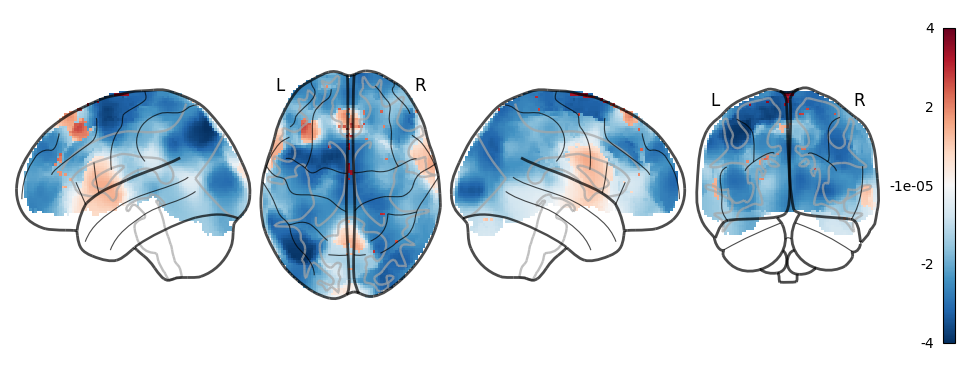

In [9]:
data_nifti.X = dm.convolve().add_dct_basis(duration=100).add_poly(0)
stats_output = data_nifti.regress()

nogo_v_go = stats_output['beta'][data_nifti.X.columns.str.contains('no_go_c0')] - stats_output['beta'][data_nifti.X.columns.str.match('go_c0')]
nogo_v_go.write(os.path.join(base_dir, 'Analyses', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_NoGoVGo_nltools.nii.gz"))

nogo_v_go.plot(view='glass')
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_NoGoVGo_nltools.png"), dpi=150)
plt.show()


#### Run using nibabel 4 x 4 x 4 original sampling

/var/folders/5b/m183lc3x27n9krrzz85z2x1c0000gn/T/ipykernel_33707/3441244122.py:9: RuntimeWarning: invalid value encountered in divide
  flattened_dat = ((flattened_dat.T - np.nanmean(flattened_dat, axis=1))/ np.nanstd(flattened_dat, axis=1)).T # z-score


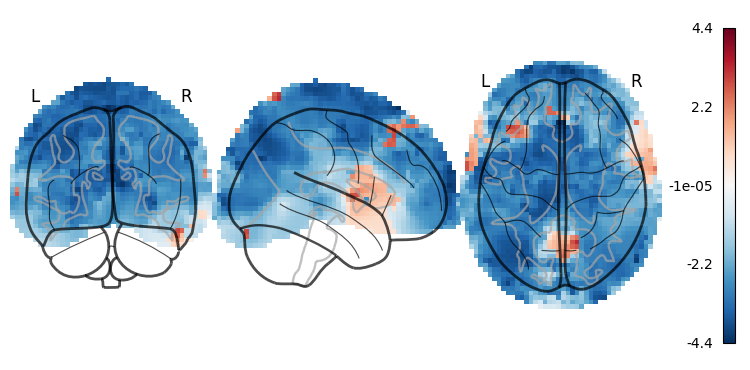

/opt/anaconda3/envs/mne/lib/python3.11/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(


In [33]:
# Load Data using Nibabel
data_nib =  nib.load(os.path.join(base_dir, 'Data', metadata['task_name'],  f'Test_{metadata["subject"]}_{metadata["task_id"]}_HbO.nii.gz') )
dat_nib = data_nib.get_fdata()
# dat_nib[data_nib==0] = np.nan

# Run vectorized regression at each voxel
dm_nib = dm.convolve().add_dct_basis(duration=100).add_poly(0)
flattened_dat = dat_nib.reshape(-1, dat_nib.shape[-1])
flattened_dat = ((flattened_dat.T - np.nanmean(flattened_dat, axis=1))/ np.nanstd(flattened_dat, axis=1)).T # z-score
b, se, t, p, df, res = regress(dm_nib, flattened_dat.T)
ngvg = b[dm_nib.columns.str.match('no_go_c0'),:] - b[dm_nib.columns.str.match('go_c0'), :]
ngvg = nib.Nifti1Image(np.nan_to_num(ngvg, nan=0.0).reshape(dat_nib.shape[:-1]), affine=data_nib.affine)
nib.save(ngvg, os.path.join(base_dir, 'Analyses', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_NoGoVGo_nibabel.nii.gz"))

# Plot glass brain
plot_glass_brain(ngvg, cmap='RdBu_r', colorbar=True, plot_abs=False)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_NoGoVGo_nibabel.png"), dpi=150)
plt.show()

view_img_on_surf(ngvg, bg_on_data=True, symmetric_cmap=True)


### Create Peristimulus Plot

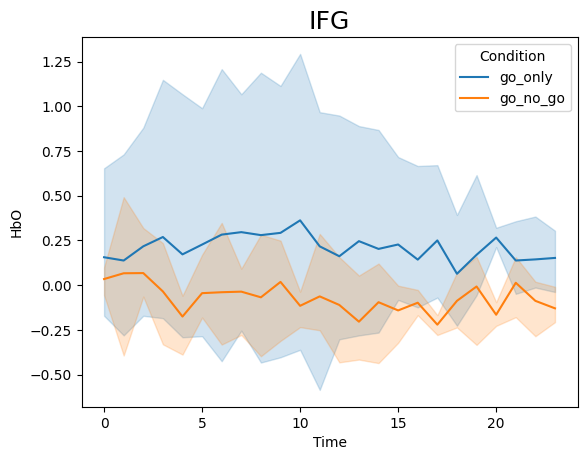

In [77]:
events['block_id'] = events['block_type'] + '_' + events['block'].fillna(0).astype(int).astype(str)
dm_block = onsets_to_dm(events.query('block_type != "rest"')[['timestamp_adjusted','duration','block_id']].rename(columns={'timestamp_adjusted':'Onset','duration':'Duration','block_id':'Stim'}), sampling_freq=1.0, run_length=len(data_nifti))

blocks = {}
for c in dm_block:
    blocks[c] = right_ifg[dm_block[c]==1]
shortest_block = np.min([blocks[x].shape for x in blocks])
blocks = pd.DataFrame({x:blocks[x][:shortest_block] for x in blocks})
blocks['Time'] = blocks.index
blocks = blocks.melt(id_vars=['Time'], var_name='Block', value_name='HbO')
blocks['Condition'] = [x[:-2] for x in blocks['Block']]

# f,a = plt.subplots(ncols=1, figsize=(6,5), sharey=True, sharex=True)
sns.lineplot(data=blocks, x='Time', y='HbO', hue='Condition')
plt.title('IFG', size=18)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_AverageIFGActivity_Block.png"), dpi=150)
blocks.to_csv(os.path.join(base_dir, 'Analyses', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_IFG_Block.csv"), index=False)

plt.show()

## Analyze HB Moments SNIRF
We will be using functions from MNE to load and analyze the SNIRF data. 

Unfortunately, there are a few issues with using MNE. 
1) MNE has not approved a PR to load correct details from Moments or Gates https://github.com/mne-tools/mne-python/pull/9661
2) MNE does not properly scale the data (raw._data *= 1e-6)
3) MNE does not properly load data about stimulus events. Currently need to manually access the HDF5 containers

In [4]:
# metadata = {'subject':'S001', 'task_name':'GoNoGo', 'task_id':'8e7c446'}
metadata = {'subject':'S003', 'task_name':'GoNoGo', 'task_id':'5b7a6da'}

# Load data
snirf_file = os.path.join(base_dir, 'Data', metadata["task_name"],  f'Test_{metadata["subject"]}_{metadata["task_id"]}_5.snirf')
raw = load_snirf_file(snirf_file)

# Get information about each optode
probe_data = get_optodes(snirf_file) 

# Apply filter
raw = raw.filter(0.01, 0.1, h_trans_bandwidth=0.01, l_trans_bandwidth=0.01)


Loading /Users/lukechang/Dropbox/Kernel/Data/GoNoGo/Test_S003_5b7a6da_5.snirf
Reading 0 ... 907  =      0.000 ...   241.262 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.10 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.11 Hz)
- Filter length: 1241 samples (330.106 s)



/var/folders/5b/m183lc3x27n9krrzz85z2x1c0000gn/T/ipykernel_33707/1841253057.py:12: RuntimeWarning: filter_length (1241) is longer than the signal (908), distortion is likely. Reduce filter length or filter a longer signal.
  raw = raw.filter(0.01, 0.1, h_trans_bandwidth=0.01, l_trans_bandwidth=0.01)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Do

Used Annotations descriptions: ['StartTrial']
Not setting metadata
144 matching events found
Setting baseline interval to [-5.054, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 144 events and 189 original time points ...
24 bad epochs dropped


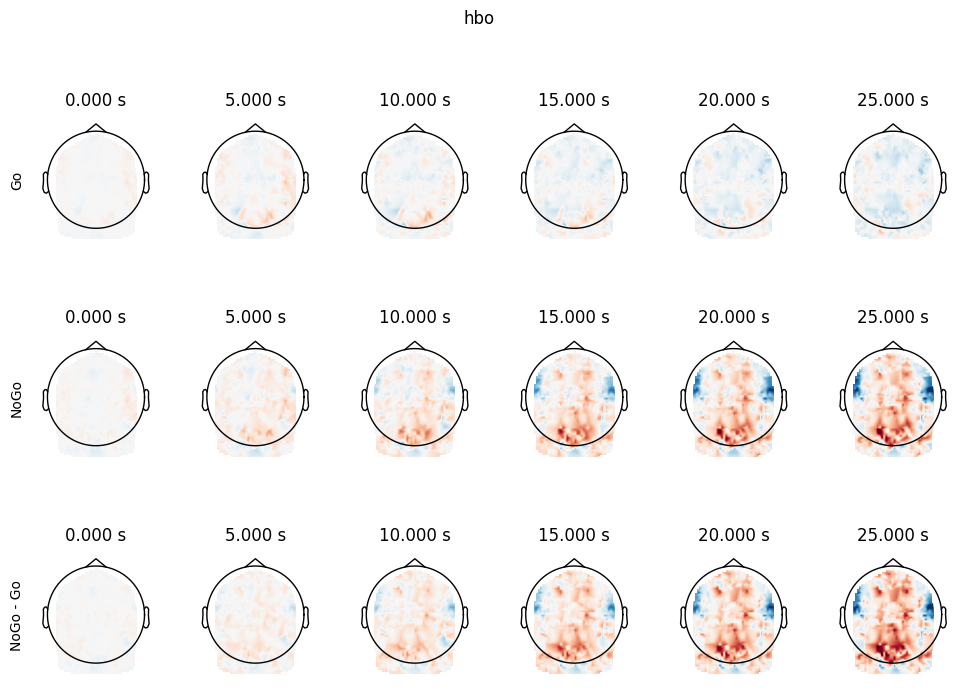

In [5]:
# Create Events
stim_data = extract_stimulus_data(snirf_file)
stim_name = 'StartTrial'
blocks = stim_data[stim_name]
events, _ = mne.events_from_annotations(raw, {stim_name: 1})
event_dict = {"NoGo": 1, "Go": 2}
events[stim_data['StartTrial']['TrialType.NoGo'] == 1, 2]  = event_dict["NoGo"]
events[stim_data['StartTrial']['TrialType.Go'] == 1, 2]  = event_dict["Go"]

# Create MNE Epochs
tmin, tmax = -5, 45
epochs = mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=tmin,
    tmax=tmax,
    proj=True,
    baseline=(None, 0),
    preload=True,
    detrend=None,
    verbose=True,
)

# Compute Averages for each condition of channels greater than 15mm and less than 30 mm
idx_channels = pick_channels_from_distance_mne_epochs(snirf_file, epochs, min_distance=15, max_distance=30)
nogo_evoked = epochs["NoGo"].average(picks=idx_channels)
go_evoked = epochs["Go"].average(picks=idx_channels)
nogo_go_evoked = nogo_evoked.copy()
nogo_go_evoked._data = nogo_evoked._data - go_evoked._data

# Create stimulus evoked topoplot
chromophore = "hbo"
times = [0, 5, 10, 15, 20, 25]
vlim = (-7, 7)

plot_topo_kwargs = dict(
    ch_type=chromophore,
    sensors=False,
    image_interp="linear",
    vlim=vlim,
    extrapolate="local",
    contours=0,
    colorbar=False,
    show=False,
)

fig, ax = plt.subplots(
    figsize=(12, 8), nrows=3, ncols=len(times), sharex=True, sharey=True
)

for idx_time, time in enumerate(times):
    _ = go_evoked.plot_topomap([time], axes=ax[0][idx_time], **plot_topo_kwargs)
    _ = nogo_evoked.plot_topomap([time], axes=ax[1][idx_time], **plot_topo_kwargs)
    _ = nogo_go_evoked.plot_topomap([time], axes=ax[2][idx_time], **plot_topo_kwargs)
    if idx_time == 0:
        ax[0][0].set_ylabel("Go")
        ax[1][0].set_ylabel("NoGo")
        ax[2][0].set_ylabel("NoGo - Go")
fig.suptitle(chromophore)
plt.savefig(os.path.join(base_dir, 'Figures', metadata['task_name'], f"{metadata['subject']}_{metadata['task_name']}_mne_topoplot.png"), dpi=150)
plt.show()